# 敵対的生成ネットワーク(GAN)

## オートエンコーダ
エンコーダとデコーダのネットワークでできている。  
基本的に潜在ベクトルの次元は入力より小さいのが一般的だが、次元が大きいovercompleteと呼ばれるカテゴリもある。このようなオートエンコーダはノイズ削減に利用できる。  
2つのサブネットワークに非線形性がない場合、PCAとほぼ同じ。

オートエンコーダでは、zの分布は分からないが、生成モデルでは、zの分布を完全に特徴づけることができる。ただし、オートエンコーダを生成モデルとして一般化することもでき、**変分オートエンコーダ**(VAE)はそうしたアプローチの一つ。他にも、自己回帰モデルや正規化フローモデルなどがある。

## GAN
ランダムベクトルから出力画像xを生成する生成器(generator:G)がある。より改善するためにどうにかしてこの生成画像の品質を評価する評価関数が欲しい。  
そこで、生成画像か本物の画像か0, 1で識別する識別器(discriminator:D)を用意し、敵対的に一緒に訓練することで改善していく。  
価値関数：  
$$
V(\theta^{(D)}, \theta^{(G)})=E_{x~P_{data}(x)}[\log D(x)]+E_{z~P_{z}(z)}[\log (1-D(G(z)))]
$$
識別器に対しては最大化したいが、生成器に対しては最小化したい。1つの訓練ステップで2つの最適化ステップを繰り返す。

### 2つの分布間の非類似度
| 指標        | 数式                                                  |
|-------------|-------------------------------------------------------|
| 全変動 (TV) | $TV(P, Q) = \sup_{x} \|P(x) - Q(x)\|$ |
| KL情報量 | $KL(P\|\|Q) = \int P(x) \log \frac{P(x)}{Q(x)}$ |
|JS情報量　|　$JS(P, Q)=\frac{1}{2} (KL(P\|\|\frac{P+Q}{2})+KL(Q\|\|\frac{P+Q}{2}))$|
|EM距離|$EM(P, Q)={inf}_{\gamma \in \Pi(P,Q)} E_{(u, v)\in \gamma}(\|\|u-v\|\|)$|


In [1]:
import torch
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: mps


In [2]:
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# 生成機のヘルパー関数
def make_generator_network(input_size=20, num_hidden_layers=1, num_hidden_units=100, num_output_units=784):
    model = nn.Sequential()
    for i in range(num_hidden_layers):
        model.add_module(f'fc_g{i}', nn.Linear(input_size, num_hidden_units))
        model.add_module(f'relu_g{i}', nn.LeakyReLU())
        input_size = num_hidden_units

    model.add_module(f'fc_g{num_hidden_layers}', nn.Linear(input_size, num_output_units))
    model.add_module('tanh_g', nn.Tanh())
    return model

# 識別器のヘルパー関数
def make_discriminator_network(input_size=784, num_hidden_layers=1, num_hidden_units=100, num_output_units=1):
    model = nn.Sequential()
    for i in range(num_hidden_layers):
        model.add_module(f'fc_d{i}', nn.Linear(input_size, num_hidden_units, bias=False))
        model.add_module(f'relu_d{i}', nn.LeakyReLU())
        model.add_module(f'dropout', nn.Dropout(p=0.5))
        input_size = num_hidden_units

    model.add_module(f'fc_d{num_hidden_layers}', nn.Linear(input_size, num_output_units))
    model.add_module('sigmoid_d', nn.Sigmoid())
    return model

In [3]:
image_size = (28, 28)
z_size = 20
gen_hidden_layers = 1
gen_hidden_size = 100
disc_hidden_layers = 1
disc_hidden_size = 100
torch.manual_seed(1)
gen_model = make_generator_network(input_size=z_size,
                                  num_hidden_layers=gen_hidden_layers,
                                  num_hidden_units=gen_hidden_size,
                                  num_output_units=np.prod(image_size))
print(gen_model)
disc_model = make_discriminator_network(input_size=np.prod(image_size),
                                        num_hidden_layers=disc_hidden_layers,
                                        num_hidden_units=disc_hidden_size,
                                        num_output_units=1)
print(disc_model)

Sequential(
  (fc_g0): Linear(in_features=20, out_features=100, bias=True)
  (relu_g0): LeakyReLU(negative_slope=0.01)
  (fc_g1): Linear(in_features=100, out_features=784, bias=True)
  (tanh_g): Tanh()
)
Sequential(
  (fc_d0): Linear(in_features=784, out_features=100, bias=False)
  (relu_d0): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_d1): Linear(in_features=100, out_features=1, bias=True)
  (sigmoid_d): Sigmoid()
)


In [4]:
import torchvision
from torchvision import datasets, transforms

path='../第12章_ニューラルネットワークの訓練をPyTorchで並列化する'
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])
mnist_dataset = torchvision.datasets.MNIST(
    root=path,
    train=True,
    download=False,
    transform=transform
)
example, label = next(iter(mnist_dataset))
print(f'Min: {example.min()}, Max: {example.max()}')
print(example.shape)

Min: -1.0, Max: 1.0
torch.Size([1, 28, 28])


In [5]:
def create_noise(batch_size, z_size, mode_z):
    if mode_z == 'uniform':
        input_z = torch.rand(batch_size, z_size)*2 - 1
    elif mode_z == 'normal':
        input_z = torch.randn(batch_size, z_size)
    return input_z

In [6]:
from torch.utils.data import DataLoader

batch_size = 32
dataloader = DataLoader(mnist_dataset, batch_size, shuffle=True)
input_real, label = next(iter(dataloader))
input_real = input_real.view(batch_size, -1)
torch.manual_seed(1)
mode_z = 'uniform'  # 'uniform' or 'normal'
input_z = create_noise(batch_size, z_size, mode_z)
print('input-z -- shape:', input_z.shape)
print('input-real -- shape:', input_real.shape)

g_output = gen_model(input_z)
print('g_output -- shape:', g_output.shape)

d_proba_real = disc_model(input_real)
d_proba_fake = disc_model(g_output)
print('Disc. (real) -- shape:', d_proba_real.shape)
print('Disc. (fake) -- shape:', d_proba_fake.shape)

input-z -- shape: torch.Size([32, 20])
input-real -- shape: torch.Size([32, 784])
g_output -- shape: torch.Size([32, 784])
Disc. (real) -- shape: torch.Size([32, 1])
Disc. (fake) -- shape: torch.Size([32, 1])


In [7]:
loss_fn = nn.BCELoss()

# 生成器の損失関数
g_labels_real = torch.ones_like(d_proba_fake)
g_loss = loss_fn(d_proba_fake, g_labels_real)
print(f'Generator loss: {g_loss:.4f}')

# 識別器の損失関数
d_labels_real = torch.ones_like(d_proba_real)
d_labels_fake = torch.zeros_like(d_proba_fake)
d_loss_real = loss_fn(d_proba_real, d_labels_real)
d_loss_fake = loss_fn(d_proba_fake, d_labels_fake)
print(f'Discriminator loss Real: {d_loss_real:.4f} Fake: {d_loss_fake:.4f}')

Generator loss: 0.6944
Discriminator loss Real: 0.7717 Fake: 0.6924


In [8]:
batch_size = 64
torch.manual_seed(1)
np.random.seed(1)
mnist_dl = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

gen_model = make_generator_network(input_size=z_size,
                                   num_hidden_layers=gen_hidden_layers,
                                   num_hidden_units=gen_hidden_size,
                                   num_output_units=np.prod(image_size)).to(device)
disc_model = make_discriminator_network(input_size=np.prod(image_size),
                                         num_hidden_layers=disc_hidden_layers,
                                         num_hidden_units=disc_hidden_size,
                                         num_output_units=1).to(device)
loss_fn = nn.BCELoss()
g_optimizer = torch.optim.Adam(gen_model.parameters())
d_optimizer = torch.optim.Adam(disc_model.parameters())

In [9]:
# 識別器を訓練する関数
def d_train(x):
    disc_model.zero_grad()
    # 本物の画像からなるバッチを使って識別器を訓練
    batch_size = x.size(0)
    x = x.view(batch_size, -1).to(device)
    d_labels_real = torch.ones(batch_size, 1, device=device)
    d_proba_real = disc_model(x)
    d_loss_real = loss_fn(d_proba_real, d_labels_real)
    # 偽物の画像からなるバッチを使って識別器を訓練
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_output = gen_model(input_z)
    d_proba_fake = disc_model(g_output)
    d_labels_fake = torch.zeros(batch_size, 1, device=device)
    d_loss_fake = loss_fn(d_proba_fake, d_labels_fake)
    # 勾配を逆伝播し、識別器のパラメータだけを最適化
    d_loss = d_loss_real + d_loss_fake
    d_loss.backward()
    d_optimizer.step()
    return d_loss.item(), d_proba_real.detach(), d_proba_fake.detach()

# 生成器を訓練する関数
def g_train(x):
    gen_model.zero_grad()
    batch_size = x.size(0)
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_labels_real = torch.ones(batch_size, 1, device=device)
    g_output = gen_model(input_z)
    d_proba_fake = disc_model(g_output)
    g_loss = loss_fn(d_proba_fake, g_labels_real)
    # 勾配を逆伝播し、生成器のパラメータだけを最適化
    g_loss.backward()
    g_optimizer.step()
    return g_loss.item()

In [10]:
fixed_z = create_noise(batch_size, z_size, mode_z).to(device)
def create_samples(g_model, input_z):
    g_output = g_model(input_z)
    images = torch.reshape(g_output, (batch_size, *image_size))
    return (images + 1) / 2  # [-1, 1] -> [0, 1]

epoch_samples = []
all_d_losses = []
all_g_losses = []
all_d_real = []
all_d_fake = []
num_epochs = 100

for epoch in range(1, num_epochs + 1):
    d_losses, g_losses = [], []
    d_vals_real, d_vals_fake = [], []
    for i, (x, _) in enumerate(mnist_dl):
        d_loss, d_proba_real, d_proba_fake = d_train(x)
        g_loss = g_train(x)
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        d_vals_real.append(d_proba_real.mean().cpu())
        d_vals_fake.append(d_proba_fake.mean().cpu())
    
    all_d_losses.append(torch.tensor(d_losses).mean())
    all_g_losses.append(torch.tensor(g_losses).mean())
    all_d_real.append(torch.tensor(d_vals_real).mean())
    all_d_fake.append(torch.tensor(d_vals_fake).mean())
    print(f'Epoch {epoch:03d} | Avg Losses >>'
          f' G/D {all_g_losses[-1]:.4f}/{all_d_losses[-1]:.4f}'
          f' [D-Real: {all_d_real[-1]:.4f}, D-Fake: {all_d_fake[-1]:.4f}]')
    epoch_samples.append(create_samples(gen_model, fixed_z).detach().cpu().numpy())

Epoch 001 | Avg Losses >> G/D 0.8846/0.9432 [D-Real: 0.7822, D-Fake: 0.4748]
Epoch 002 | Avg Losses >> G/D 1.0114/1.0992 [D-Real: 0.6251, D-Fake: 0.4160]
Epoch 003 | Avg Losses >> G/D 0.9576/1.1987 [D-Real: 0.5754, D-Fake: 0.4229]
Epoch 004 | Avg Losses >> G/D 0.9002/1.2390 [D-Real: 0.5679, D-Fake: 0.4416]
Epoch 005 | Avg Losses >> G/D 1.0322/1.1744 [D-Real: 0.5929, D-Fake: 0.4100]
Epoch 006 | Avg Losses >> G/D 1.0219/1.1602 [D-Real: 0.5998, D-Fake: 0.4036]
Epoch 007 | Avg Losses >> G/D 1.0620/1.1531 [D-Real: 0.6046, D-Fake: 0.4004]
Epoch 008 | Avg Losses >> G/D 1.0320/1.1458 [D-Real: 0.6057, D-Fake: 0.4015]
Epoch 009 | Avg Losses >> G/D 1.0201/1.1665 [D-Real: 0.5973, D-Fake: 0.4023]
Epoch 010 | Avg Losses >> G/D 1.0643/1.1544 [D-Real: 0.6043, D-Fake: 0.3985]
Epoch 011 | Avg Losses >> G/D 1.0818/1.1462 [D-Real: 0.6089, D-Fake: 0.3961]
Epoch 012 | Avg Losses >> G/D 1.0010/1.1597 [D-Real: 0.6000, D-Fake: 0.4041]
Epoch 013 | Avg Losses >> G/D 0.9613/1.2016 [D-Real: 0.5853, D-Fake: 0.4175]

<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:16: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:16: SyntaxWarning: invalid escape sequence '\m'
/var/folders/zg/773ptkr55z99zw26dvy19_v00000gn/T/ipykernel_77948/2619119009.py:15: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(all_d_real, label='Real: $D(\mathbf{x})$')
/var/folders/zg/773ptkr55z99zw26dvy19_v00000gn/T/ipykernel_77948/2619119009.py:16: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(all_d_fake, label='Fake: $D(G(\mathbf{z}))$')


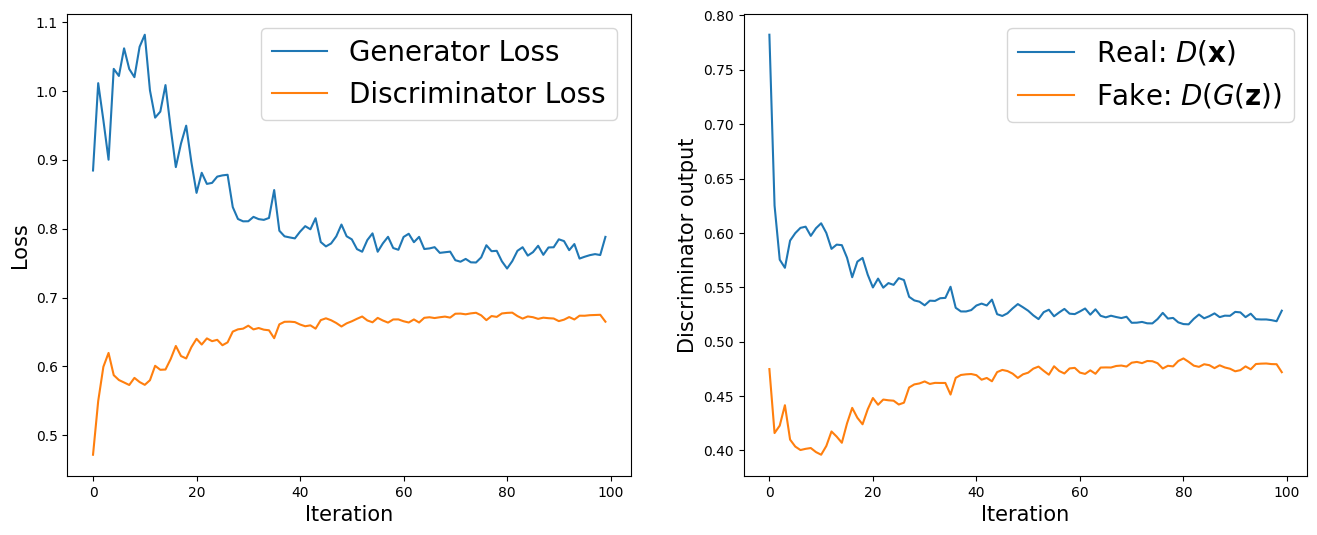

In [11]:
import itertools

fig = plt.figure(figsize=(16, 6))
# 損失値をプロット
ax = fig.add_subplot(1, 2, 1)
plt.plot(all_g_losses, label='Generator Loss')
half_d_losses = [x / 2 for x in all_d_losses]
plt.plot(half_d_losses, label='Discriminator Loss')
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', fontsize=15)
ax.set_ylabel('Loss', fontsize=15)

# 識別器の出力をプロット
ax = fig.add_subplot(1, 2, 2)
plt.plot(all_d_real, label='Real: $D(\mathbf{x})$')
plt.plot(all_d_fake, label='Fake: $D(G(\mathbf{z}))$')
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', fontsize=15)
ax.set_ylabel('Discriminator output', fontsize=15)
plt.show()

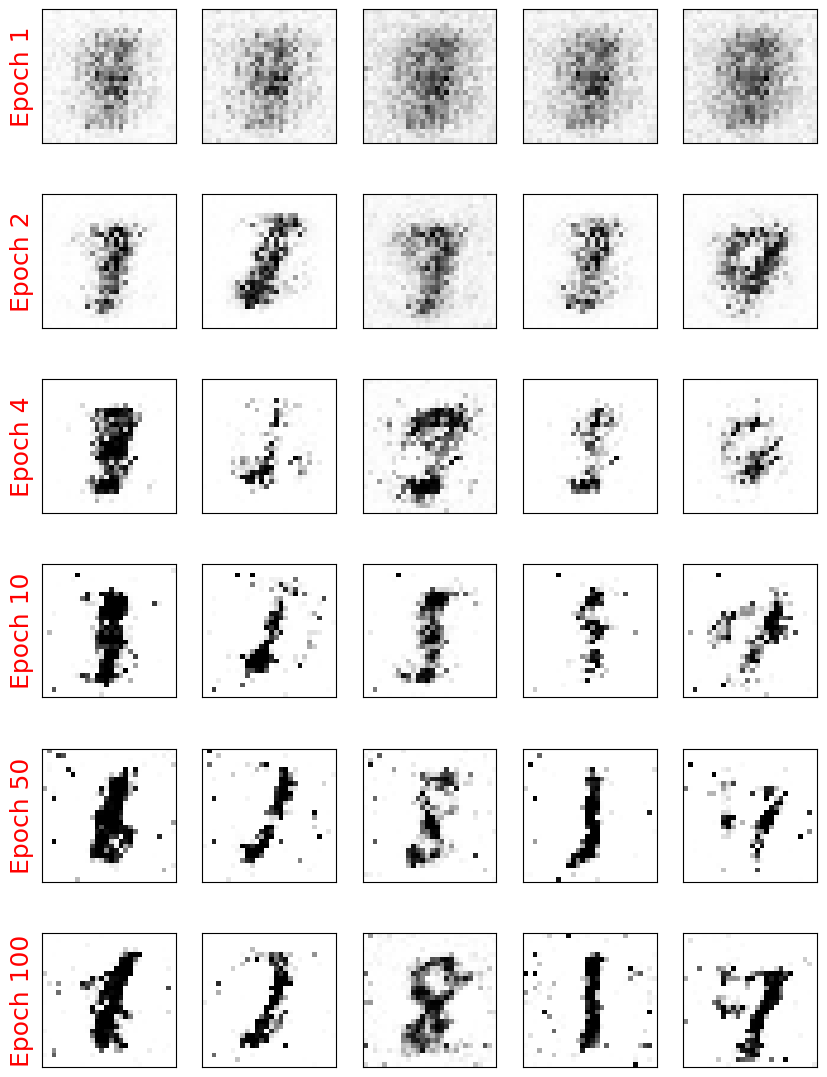

In [12]:
selected_epochs = [1, 2, 4, 10, 50, 100]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i*5+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(-0.06, 0.5, f'Epoch {e}', rotation=90, size=18, color='red', horizontalalignment='right', verticalalignment='center', transform=ax.transAxes)
        image = epoch_samples[e-1][j]
        ax.imshow(image, cmap='gray_r')

plt.show()

In [14]:
gen_path = 'gen_model.pt'
torch.save(gen_model, gen_path)
disc_path = 'disc_model.pt'
torch.save(disc_model, disc_path)

全結合層が1つの非常に単純なGANであるため生成画像は荒い。